##Task 1

## 1) Explain how feature matching can address the instability in training GANs.

Feature matching addresses instability by altering the generator's objective. Rather than optimizing the generator to directly fool the discriminator, it is trained to generate data that matches certain statistical properties of real data. These properties are the intermediate activations from a layer of the discriminator. This approach stabilizes training by ensuring that the generator focuses on generating data that closely matches the statistics of the real data distribution, reducing oscillations and mode collapse, which are common causes of instability​(NIPS-2016-improved-tech…).

## 2) What is meant by mode collapse in GANs?

Mode collapse occurs when the generator produces a limited diversity of outputs. Instead of learning to generate a wide variety of samples from the data distribution, the generator may produce only a single output or a few outputs, regardless of the input noise vector. This happens because the generator learns to exploit specific weaknesses in the discriminator, leading to repetitive generation of a single type of data rather than a full representation of the target distribution​(2005.00065v1)​(NIPS-2016-improved-tech…).

## 3) Explain the concept of minibatch discrimination.

Minibatch discrimination is a technique used to prevent mode collapse by allowing the discriminator to evaluate multiple samples together rather than independently. This enables the discriminator to detect patterns across a batch, comparing how similar or different the samples are. By encouraging the generator to produce more diverse samples, minibatch discrimination helps ensure that the outputs are not all similar, addressing one of the root causes of mode collapse​(NIPS-2016-improved-tech…).

## 4) Explain the significance of the following terms with respect to GANs:

**Historical averaging:**\
 Historical averaging helps stabilize GAN training by including a regularization term that penalizes deviations from the average of past model parameters. This discourages sudden large updates and can smooth out training, reducing oscillations​(NIPS-2016-improved-tech…).

**One-sided label smoothing:**\
 This technique involves modifying the labels used to train the discriminator. Instead of labeling real data as 1 and fake data as 0, the labels are smoothed (e.g., real data could be labeled as 0.9 instead of 1). This prevents the discriminator from becoming overly confident and overfitting, which can lead to vanishing gradients​(NIPS-2016-improved-tech…).

**Virtual batch normalization:**\
 Similar to batch normalization, virtual batch normalization normalizes a sample based on the statistics of a fixed reference batch of data. This allows for better consistency in how individual samples are processed, reducing the sensitivity of training to the specific examples in each minibatch and improving stability​(NIPS-2016-improved-tech…).

## 5) What are the proposed suggestions to stabilize the training in GANs?


**Several techniques are suggested to stabilize GAN training:**

- Feature matching to ensure the generator produces samples that match the statistics of real data.
- Minibatch discrimination to encourage diversity in the generated samples.
- Historical averaging to smooth updates to the parameters.
- One-sided label smoothing to prevent the discriminator from becoming too confident.
- Virtual batch normalization to improve stability during training​(NIPS-2016-improved-tech…)​(2005.00065v1).

## 6) Define and explain the JS divergence loss as used in GANs. How is it better than KL divergence loss used in VAEs?

In GANs, the generator and discriminator are optimized using Jensen-Shannon (JS) divergence, which measures the similarity between the real and generated data distributions. Unlike KL divergence (used in VAEs), which can assign infinite penalties if there is no overlap between the distributions, JS divergence provides a more stable gradient in this scenario. KL divergence focuses on minimizing the distance between distributions, which can be problematic when the overlap is small. JS divergence handles this better, making it more suitable for GANs where the generator is trying to "fool" the discriminator​(2005.00065v1).

## 7) Define Wasserstein distance. Why is Wasserstein better than JS or KL divergence?

Wasserstein distance measures the "cost" of transforming one distribution into another, providing a more interpretable and smoother gradient than JS or KL divergence. It addresses mode collapse and instability issues by offering meaningful feedback even when the generator and real data distributions do not overlap. For example, while JS and KL divergences may lead to vanishing gradients when the distributions are too far apart, Wasserstein distance provides stable gradients that guide the generator toward better solutions​(2005.00065v1).

## 8) Explain the term Lipschitz continuity.

Lipschitz continuity is a mathematical condition that bounds how much a function can change between any two points. In the context of GANs, enforcing a Lipschitz constraint (often through weight clipping or gradient penalties) ensures that the discriminator does not have excessively steep gradients, which could destabilize training. This constraint is crucial for stabilizing the Wasserstein GAN (WGAN)​(2005.00065v1).

## 9) Compared to the original GAN algorithm, state the changes made for WGAN implementation.

WGAN introduces the following changes:

- Wasserstein distance is used instead of JS divergence, providing more stable gradients.
- Weight clipping is applied to enforce the Lipschitz continuity requirement, which ensures that the discriminator remains within a controlled range and prevents it from overfitting or producing sharp gradients​(2005.00065v1).

##DCGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
image_size = 32
num_channels = 3
latent_size = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0002

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(cifar_data, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 47447830.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, img):
        return self.model(img).view(-1)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def show_generated_images(generator, fixed_noise):
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake_imgs, nrow=8, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

Epoch [1/50], d_loss: 1.3544, g_loss: 2.0424
Epoch [2/50], d_loss: 0.2599, g_loss: 2.8821
Epoch [3/50], d_loss: 0.5221, g_loss: 2.1873
Epoch [4/50], d_loss: 0.2371, g_loss: 2.0132
Epoch [5/50], d_loss: 1.0859, g_loss: 6.4040


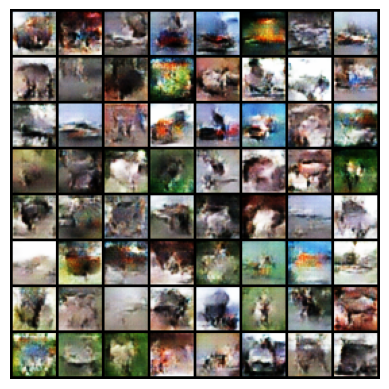

Epoch [6/50], d_loss: 0.5122, g_loss: 2.6998
Epoch [7/50], d_loss: 1.4800, g_loss: 0.3560
Epoch [8/50], d_loss: 0.2131, g_loss: 3.0556
Epoch [9/50], d_loss: 0.4323, g_loss: 1.8367
Epoch [10/50], d_loss: 0.3434, g_loss: 2.7408


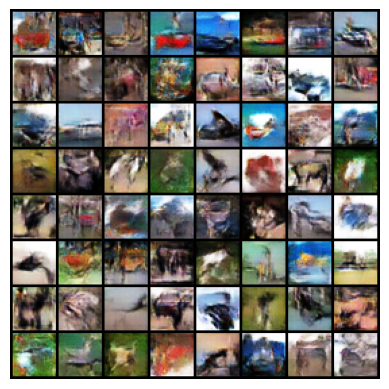

Epoch [11/50], d_loss: 0.9870, g_loss: 5.1210
Epoch [12/50], d_loss: 0.2598, g_loss: 2.4765
Epoch [13/50], d_loss: 0.9040, g_loss: 0.5540
Epoch [14/50], d_loss: 0.2379, g_loss: 4.1099
Epoch [15/50], d_loss: 0.1457, g_loss: 3.8220


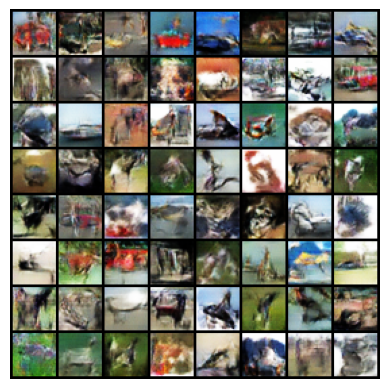

Epoch [16/50], d_loss: 0.1606, g_loss: 4.3924
Epoch [17/50], d_loss: 0.1230, g_loss: 4.9713
Epoch [18/50], d_loss: 0.3239, g_loss: 4.0998
Epoch [19/50], d_loss: 0.2135, g_loss: 3.0578
Epoch [20/50], d_loss: 0.0918, g_loss: 5.2474


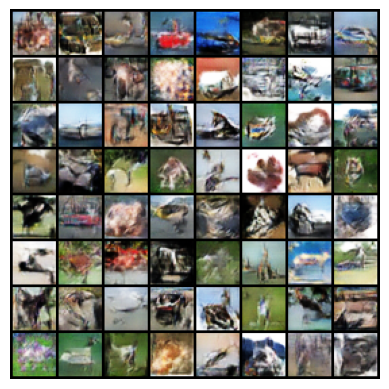

Epoch [21/50], d_loss: 0.2112, g_loss: 4.0579
Epoch [22/50], d_loss: 0.4993, g_loss: 0.3901
Epoch [23/50], d_loss: 0.3202, g_loss: 7.1715
Epoch [24/50], d_loss: 0.2817, g_loss: 2.4660
Epoch [25/50], d_loss: 0.1633, g_loss: 3.9367


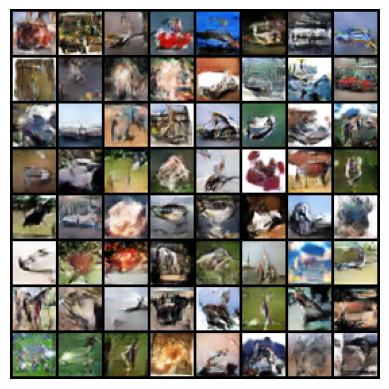

Epoch [26/50], d_loss: 0.1239, g_loss: 4.1739
Epoch [27/50], d_loss: 0.0612, g_loss: 4.7342
Epoch [28/50], d_loss: 0.0783, g_loss: 6.7958
Epoch [29/50], d_loss: 0.0737, g_loss: 5.0645
Epoch [30/50], d_loss: 0.4253, g_loss: 8.3325


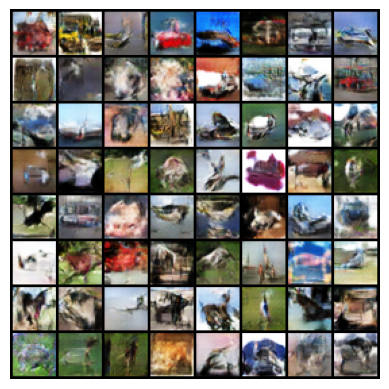

Epoch [31/50], d_loss: 0.0896, g_loss: 4.4761
Epoch [32/50], d_loss: 0.0178, g_loss: 5.4875
Epoch [33/50], d_loss: 0.0333, g_loss: 5.3967
Epoch [34/50], d_loss: 0.0595, g_loss: 5.1267
Epoch [35/50], d_loss: 0.0555, g_loss: 5.4487


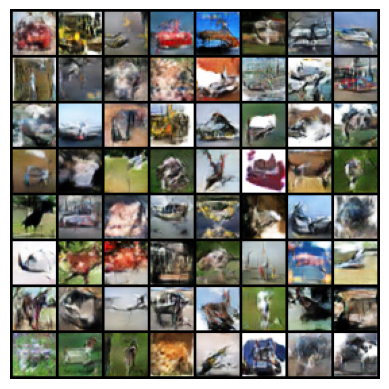

Epoch [36/50], d_loss: 0.0693, g_loss: 6.5794
Epoch [37/50], d_loss: 0.4185, g_loss: 8.2687
Epoch [38/50], d_loss: 0.0551, g_loss: 5.6895
Epoch [39/50], d_loss: 0.1948, g_loss: 8.9268
Epoch [40/50], d_loss: 0.0540, g_loss: 5.1856


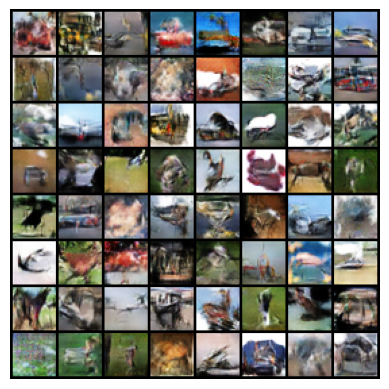

Epoch [41/50], d_loss: 0.5575, g_loss: 0.8225
Epoch [42/50], d_loss: 0.0611, g_loss: 6.0111
Epoch [43/50], d_loss: 0.2387, g_loss: 4.8312
Epoch [44/50], d_loss: 0.0361, g_loss: 5.7476
Epoch [45/50], d_loss: 0.1082, g_loss: 3.6019


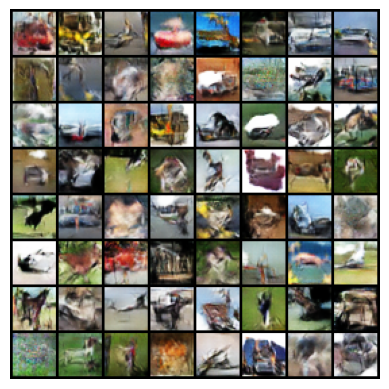

Epoch [46/50], d_loss: 0.0758, g_loss: 4.0208
Epoch [47/50], d_loss: 0.0216, g_loss: 5.7929
Epoch [48/50], d_loss: 0.0513, g_loss: 6.6910
Epoch [49/50], d_loss: 0.1460, g_loss: 5.8755
Epoch [50/50], d_loss: 0.0472, g_loss: 5.2752


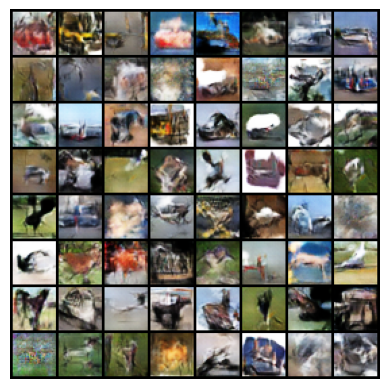

In [ ]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        d_optimizer.zero_grad()
        real_outputs = discriminator(imgs)
        d_real_loss = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        fake_outputs = discriminator(fake_imgs)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    if (epoch + 1) % 5 == 0:
        show_generated_images(generator, fixed_noise)